In [1]:
import xt_fns as xf
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import batman
from astropy.io import ascii
from astropy.table import Table
import astropy
from contextlib import closing
from astropy.time import Time

# Define a function to make the calculations of characteristics of the models

In [2]:
def calcs(fluxArr, phases, descript):
    """Function for making various calculations for the given model (depths, durations etc).
    'fluxArr' is the flux array from batman to be used in the calculations.
    'phases' is the phase array associated with the flux array
    'descript' is a description of the model for use in printing the results"""
    #in transit points
    inTrans = fluxArr < 1
    #maximum depth of the transit, as a percentage
    maxDep = (1 - np.min(fluxArr)) * 100
    #average value of the in transit points, as a percentage
    avgDep = (1 - np.mean(fluxArr[inTrans])) * 100
    #depth at the mid transit peak - works only for symmetric models
    midFlux = (1 - fluxArr[np.argmin(np.absolute(phases - 1))]) * 100
    #1st to 4th contact duration in phase units
    dur1_4 = phases[inTrans][-1] - phases[inTrans][0]
    #phase duration between two points of maximum depth - assumes symmetric model
    maxDep2maxDep =  2 * np.absolute(phases[np.argmin(fluxArr)] - 1)
    #integrated "missing" flux due to the transit. x100 to make it a %
    missFlux = np.trapz((1-fluxArr), dx=np.mean(np.diff(binPhases))) * 100
    #print the results
    print("""-------------------------------------------------
    ----Results for {0}----
    
    Maximum depth      = {1}
    Average depth      = {2}
    Mid-transit depth  = {3}
    Full duration      = {4}
    Trough to trough   = {5}
    Total missing flux = {6}
    """.format(descript, maxDep, avgDep, midFlux, dur1_4, maxDep2maxDep, missFlux))
    

# Use kT = 0.34 keV - "weighted temperature" from the Bourrier+2020 spectral fit. Plot the radial coronal model in 1D

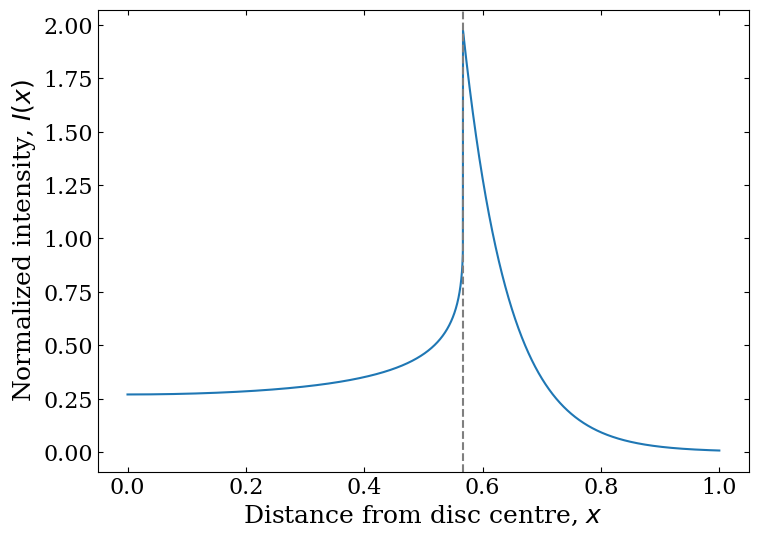

In [3]:
#Stellar parameters
Rs = 0.780 #radius (Rsun)
Ms = 0.823 #mass (Msun)
T = 0.34 #kT of corona in keV

#get emission scale height in stellar radii
He = xf.HfromT(T, Rs, Ms)
#get emission scale height in batman coordinates
he = xf.hfromH(He)


#set up x array for 10001 steps from x=0 to x=1
x = np.linspace(0, 1, 10001)
#number of emission scale heights to calculate corona out to
Nscale = 6
#photosphere edge in batman coords
Rx = xf.calcRx(he, Nscale)
#integral values
intVals = xf.get_intVals(he, Nscale)

plt.rc('font', family='serif')

#plot1D intensity variation
fig1D = plt.figure(figsize=(8.4,6.0))

plt.plot(x,intVals)
plt.axvline(x=Rx, color='C7', ls='--')

plt.xlabel('Distance from disc centre, $x$',fontsize=18)
plt.ylabel('Normalized intensity, $I(x)$',fontsize=18)
plt.tick_params(labelsize=16)

plt.savefig('1Dintensity.pdf', dpi=300)

# Now plot the emission intensity as a 2D schematic

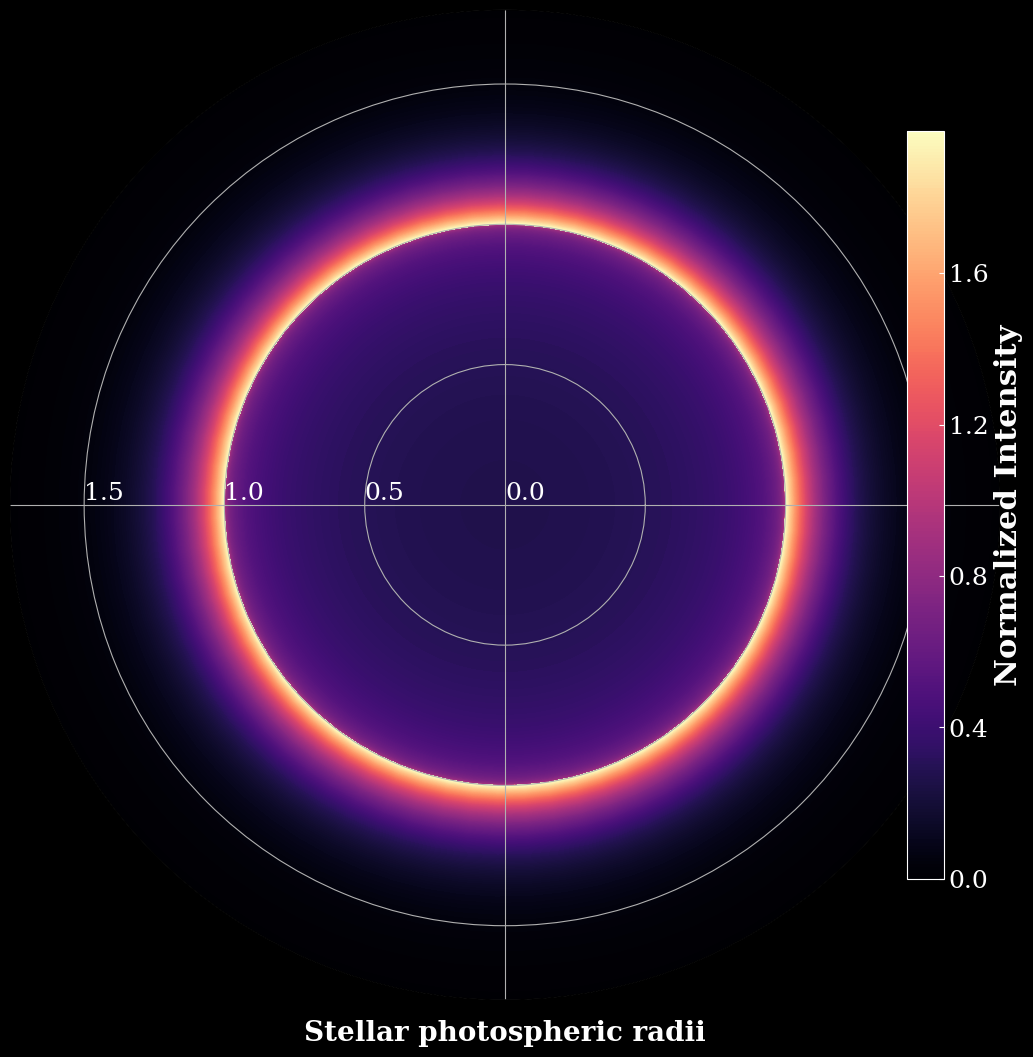

In [26]:
#set up azimuths and zeniths for contour plot
azimuths = np.radians(np.linspace(0, 360, 72))
zeniths = np.linspace(0, 1,10001)/Rx
#set up grid
r, theta = np.meshgrid(zeniths, azimuths)

#get values for first scale height choice
values1 = np.tile(intVals, (len(azimuths),1) )

#set up figure
fig2D, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection='polar'))

cmap = plt.colormaps.get_cmap("magma")

c = ax.contourf(theta, r, values1, 256, cmap=cmap)
c.set_clim( [0, np.max(values1)] )

ax.set_xticks([0,np.pi/2,np.pi,3*np.pi/2])
ax.set_yticks([0,0.5, 1, 1.5])
ax.set_rlabel_position(180)
#ax.xaxis.grid(False)
ax.set_xticklabels([])
ax.tick_params(labelsize=18, labelcolor='white')
ax.set_xlabel('Stellar photospheric radii', fontsize=20, weight='bold', color='white')

pltparams = {"text.color" : "white",
          "xtick.color" : "white",
          "ytick.color" : "white"}
plt.rcParams.update(pltparams)

#Set up colorbar
cb = plt.colorbar(c, ticks=[0,0.4,0.8,1.2,1.6,2.0], fraction=0.04, pad=-0.1)
cb.set_label(label='Normalized Intensity', fontsize=22, weight='bold', color='white')
cb.ax.tick_params(labelsize=18, labelcolor='white')
cb.outline.set_edgecolor('white')

#ax.set_rlim([0, 0.75])
fig2D.set_facecolor('black')
plt.subplots_adjust(left=0.005, bottom=0.005, right=0.94, top=0.995)

plt.savefig('2DCoronal_HeBourrier.png', dpi=300, facecolor='black')

# Now plot the transit light curve, assuming Rp,x = Rp,opt

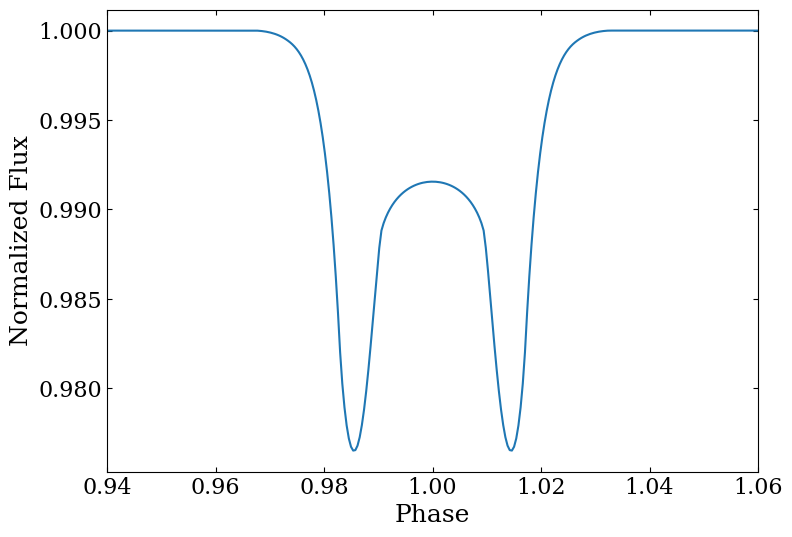

In [5]:
#planetary parameters
RpRs = 0.15641 #Rp/Rs
aRs = 8.863 #a/Rs
inc = 85.710 #inclination
t0 = 1 #phase of transit centre

#set up the object to store the transit parameters
params = batman.TransitParams()
params.t0 = t0               #time of inferior conjunction
params.per = 1               #orbital period - set to 1 to keep within phase definitions
params.rp = RpRs * Rx        #planet radius (in units of stellar radii)
params.a = aRs * Rx          #semi-major axis (in units of stellar radii)
params.inc = inc             #orbital inclination (in degrees)
params.ecc = 0.              #eccentricity
params.w = 90.               #longitude of periastron (in degrees)
params.limb_dark = "custom"  #limb darkening model
params.u = [0]*6             #limb darkening coefficients
params.u[0] = intVals

#initialise a batman model at the calcuation phase times
#Setting up times for model
phaSt, phaFi = 0.9, 1.1 #phases to model
numBins = 500 #number of bins to calculate the light curve at
binPhases = np.linspace(phaSt, phaFi, numBins) #bin centres

#set up batman model
mod = batman.TransitModel(params, binPhases)
#get the fluxes
flux1 = mod.light_curve(params)

pltparams = {"text.color" : "k",
          "xtick.color" : "k",
          "ytick.color" : "k"}
plt.rcParams.update(pltparams)


#plot the model
fig1 = plt.figure(figsize=(8.4,6.0))
plt.plot(binPhases, flux1) #Plot model
plt.xlabel('Phase',fontsize=18)
plt.ylabel('Normalized Flux',fontsize=18)
plt.tick_params(labelsize=16)
plt.xlim(0.94,1.06)

plt.savefig('optR_HeBourrier.pdf', dpi=300)

# Compare with the optical transit with a quadratic limb darkening law. We use Claret & Bloemen, assuming Teff = 4800 K, log g = 4.5 cm/s2, Z = 0 Sun, Johnson V filter

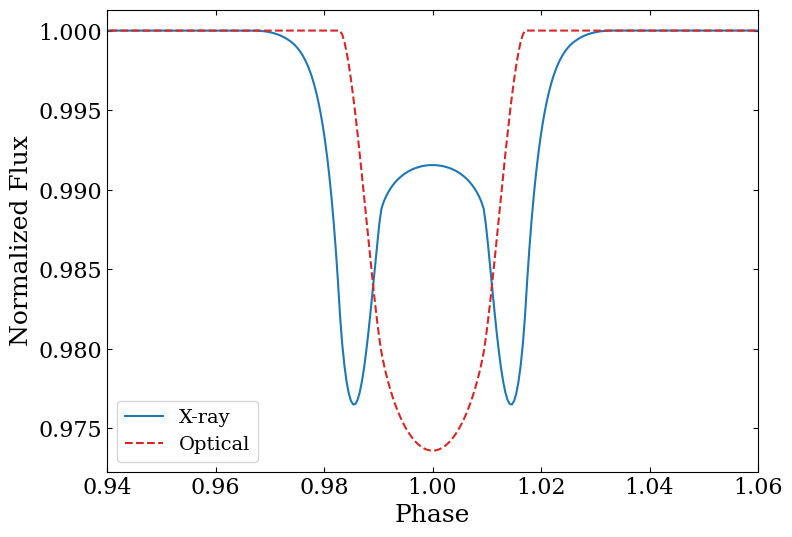

In [6]:
#set up the object to store the transit parameters
paramsOpt = batman.TransitParams()
paramsOpt.t0 = 1                  #time of inferior conjunction
paramsOpt.per = 1                 #orbital period - set to 1 to keep within phase definitions
paramsOpt.rp = RpRs               #planet radius (in units of stellar radii)
paramsOpt.a = aRs                 #semi-major axis (in units of stellar radii)
paramsOpt.inc = inc               #orbital inclination (in degrees)
paramsOpt.ecc = 0.                #eccentricity
paramsOpt.w = 90.                 #longitude of periastron (in degrees)
paramsOpt.limb_dark = "quadratic" #limb darkening model
paramsOpt.u = [0.7575,0.0534]     #limb darkening coefficients

#set up batman model
modOpt = batman.TransitModel(paramsOpt, binPhases)
#get the fluxes
fluxOpt = modOpt.light_curve(paramsOpt)

#plot the model
figOpt = plt.figure(figsize=(8.4,6.0))
plt.plot(binPhases, flux1, label='X-ray')
plt.plot(binPhases, fluxOpt, color='C3', ls='--', label='Optical')
plt.xlabel('Phase',fontsize=18)
plt.ylabel('Normalized Flux',fontsize=18)
plt.tick_params(labelsize=16)
plt.legend(loc='lower left', fontsize=14)
plt.xlim(0.94,1.06)

plt.savefig('opt_comparison.pdf', dpi=300)

### Calculations

In [7]:
calcs(flux1, binPhases, 'X-ray')
calcs(fluxOpt, binPhases, 'Optical')

-------------------------------------------------
    ----Results for X-ray----
    
    Maximum depth      = 2.3489339571795442
    Average depth      = 0.873579408707903
    Mid-transit depth  = 0.8448908194978566
    Full duration      = 0.06533066132264531
    Trough to trough   = 0.02925851703406801
    Total missing flux = 0.05742165251627167
    
-------------------------------------------------
    ----Results for Optical----
    
    Maximum depth      = 2.638902642077612
    Average depth      = 1.7375712855033476
    Mid-transit depth  = 2.638902642077612
    Full duration      = 0.034068136272545124
    Trough to trough   = 0.00040080160320643543
    Total missing flux = 0.05989223669470397
    


# Now adjust the absorber size. Use 1.5, 2, and 2.5x the optical radius

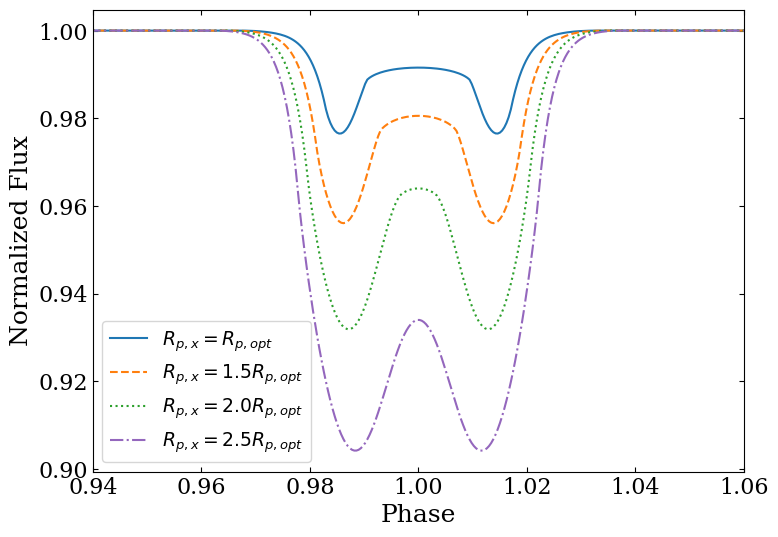

In [8]:
#1.5x the optical radius
params.rp = 1.5 * RpRs * Rx
#calculate the new fluxes
flux15 = mod.light_curve(params)

#2x the optical radius
params.rp = 2.0 * RpRs * Rx
#calculate the new fluxes
flux20 = mod.light_curve(params)

#2.5x the optical radius
params.rp = 2.5 * RpRs * Rx
#calculate the new fluxes
flux25 = mod.light_curve(params)


#plot the model
fig2 = plt.figure(figsize=(8.4,6.0))
plt.plot(binPhases, flux1, label='$R_{p,x} = R_{p,opt}$') 
plt.plot(binPhases, flux15, ls='--', label='$R_{p,x} = 1.5 R_{p,opt}$')
plt.plot(binPhases, flux20, ls=':', label='$R_{p,x} = 2.0 R_{p,opt}$')
plt.plot(binPhases, flux25, ls='-.', color='C4', label='$R_{p,x} = 2.5 R_{p,opt}$')

plt.xlabel('Phase',fontsize=18)
plt.ylabel('Normalized Flux',fontsize=18)
plt.tick_params(labelsize=16)
plt.legend(loc='lower left', fontsize=13.5)
plt.xlim(0.94,1.06)

plt.savefig('varyRadius.pdf', dpi=300)

### Calculations

In [9]:
calcs(flux1, binPhases, '1.0 Ropt')
calcs(flux15, binPhases, '1.5 Ropt')
calcs(flux20, binPhases, '2.0 Ropt')
calcs(flux25, binPhases, '2.5 Ropt')

-------------------------------------------------
    ----Results for 1.0 Ropt----
    
    Maximum depth      = 2.3489339571795442
    Average depth      = 0.873579408707903
    Mid-transit depth  = 0.8448908194978566
    Full duration      = 0.06533066132264531
    Trough to trough   = 0.02925851703406801
    Total missing flux = 0.05742165251627167
    
-------------------------------------------------
    ----Results for 1.5 Ropt----
    
    Maximum depth      = 4.394449329574412
    Average depth      = 1.9046040547419985
    Mid-transit depth  = 1.945068106342407
    Full duration      = 0.06773547094188381
    Trough to trough   = 0.027655310621242712
    Total missing flux = 0.1297726209643839
    
-------------------------------------------------
    ----Results for 2.0 Ropt----
    
    Maximum depth      = 6.813807718128917
    Average depth      = 3.260224016420188
    Mid-transit depth  = 3.602141856597285
    Full duration      = 0.07094188376753507
    Trough to trough 

# Next let's revert to the optical radius, but change the emission scale height. For a very different value, let's use a coronal temperature of 1 keV

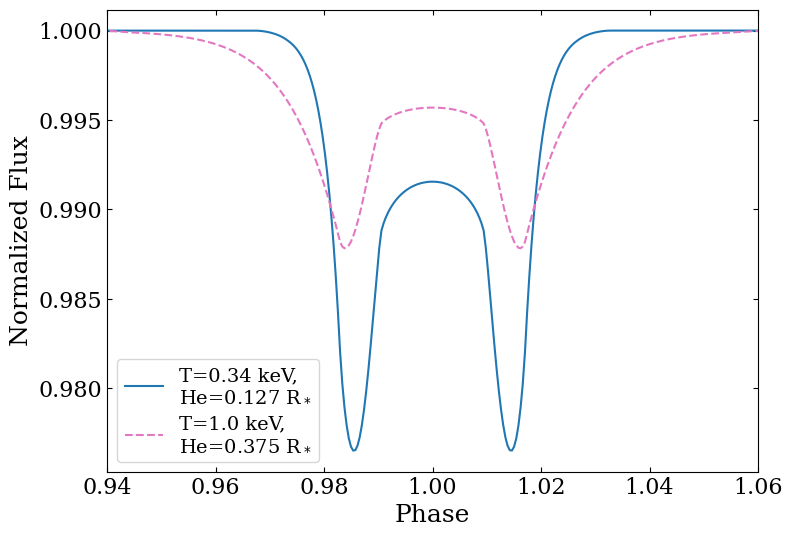

In [10]:
#new coronal temperature
T2 = 1.0
#get new emission scale height in stellar radii
He2 = xf.HfromT(T2, Rs, Ms)
#get new emission scale height in batman coordinates
he2 = xf.hfromH(He2)

#revert to optically measured radius
params.rp = 1.0 * RpRs * Rx
#photosphere edge in batman coords
Rx2 = xf.calcRx(he2, Nscale)
#integral values
intVals2 = xf.get_intVals(he2, Nscale)

#set up the object to store the transit parameters
params2 = batman.TransitParams()
params2.t0 = t0               #time of inferior conjunction
params2.per = 1               #orbital period - set to 1 to keep within phase definitions
params2.rp = RpRs * Rx2        #planet radius (in units of stellar radii)
params2.a = aRs * Rx2          #semi-major axis (in units of stellar radii)
params2.inc = inc             #orbital inclination (in degrees)
params2.ecc = 0.              #eccentricity
params2.w = 90.               #longitude of periastron (in degrees)
params2.limb_dark = "custom"  #limb darkening model
params2.u = [0]*6             #limb darkening coefficients
params2.u[0] = intVals2

#set up batman model
mod2 = batman.TransitModel(params2, binPhases)
#get the fluxes
flux2 = mod2.light_curve(params2)

#plot the model
fig2 = plt.figure(figsize=(8.4,6.0))
plt.plot(binPhases, flux1, label='T=0.34 keV,\nHe=0.127 R$_*$')
plt.plot(binPhases, flux2, color='C6', ls='--', label='T=1.0 keV,\nHe=0.375 R$_*$')

plt.xlabel('Phase',fontsize=18)
plt.ylabel('Normalized Flux',fontsize=18)
plt.tick_params(labelsize=16)
plt.legend(loc='lower left', fontsize=14)
plt.xlim(0.94,1.06)

plt.savefig('varyHe.pdf', dpi=300)

### Calculations

In [11]:
calcs(flux1, binPhases, '0.34 keV')
calcs(flux2, binPhases, '1.0 keV')

-------------------------------------------------
    ----Results for 0.34 keV----
    
    Maximum depth      = 2.3489339571795442
    Average depth      = 0.873579408707903
    Mid-transit depth  = 0.8448908194978566
    Full duration      = 0.06533066132264531
    Trough to trough   = 0.02925851703406801
    Total missing flux = 0.05742165251627167
    
-------------------------------------------------
    ----Results for 1.0 keV----
    
    Maximum depth      = 1.2173843186080058
    Average depth      = 0.35131495500885235
    Mid-transit depth  = 0.4307050511986654
    Full duration      = 0.1230460921843688
    Trough to trough   = 0.03246492985971927
    Total missing flux = 0.043368739936965314
    


# Let's plot a 1-D comparison of the emission 

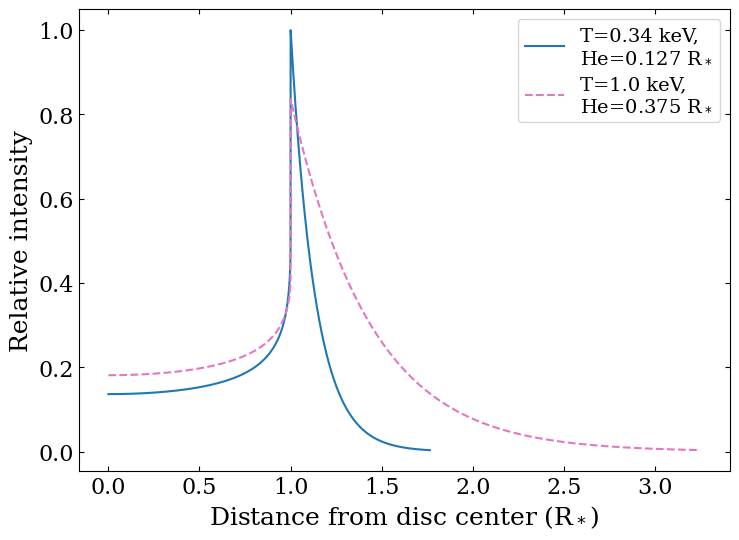

In [12]:
#First find the relative xcoords so we can plot on the same scale
x1Rel = x / Rx
x2Rel = x / Rx2
intVals2Rel = intVals2 * np.sum(intVals)/np.sum(intVals2)

#plot1D intensity variation
fig1D = plt.figure(figsize=(8.4,6.0))

plt.plot(x1Rel,intVals/np.max(intVals), label='T=0.34 keV,\nHe=0.127 R$_*$')
plt.plot(x2Rel, intVals2Rel/np.max(intVals), color='C6', ls='--', label='T=1.0 keV,\nHe=0.375 R$_*$')

plt.xlabel('Distance from disc center (R$_*$)',fontsize=18)
plt.ylabel(r'Relative intensity',fontsize=18)
plt.tick_params(labelsize=16)
plt.legend(loc='upper right', fontsize=14)

plt.savefig('1Dintensity_comp.pdf', dpi=300)

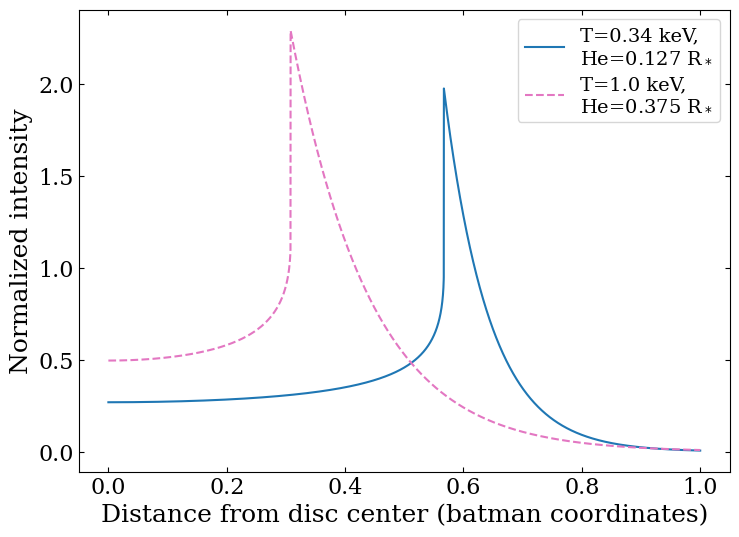

In [13]:
#plot1D intensity variation
fig1D = plt.figure(figsize=(8.4,6.0))

plt.plot(x,intVals, label='T=0.34 keV,\nHe=0.127 R$_*$')
plt.plot(x, intVals2, color='C6', ls='--', label='T=1.0 keV,\nHe=0.375 R$_*$')

plt.xlabel('Distance from disc center (batman coordinates)',fontsize=18)
plt.ylabel('Normalized intensity',fontsize=18)
plt.tick_params(labelsize=16)
plt.legend(loc='upper right', fontsize=14)

plt.savefig('1Dintensity_comp2.pdf', dpi=300)

# Let's also plot a 2-D schematic of the projection of the coronal model on the sky, for both choices of the scale height.

/tmp/ipykernel_220172/3554900839.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("magma")


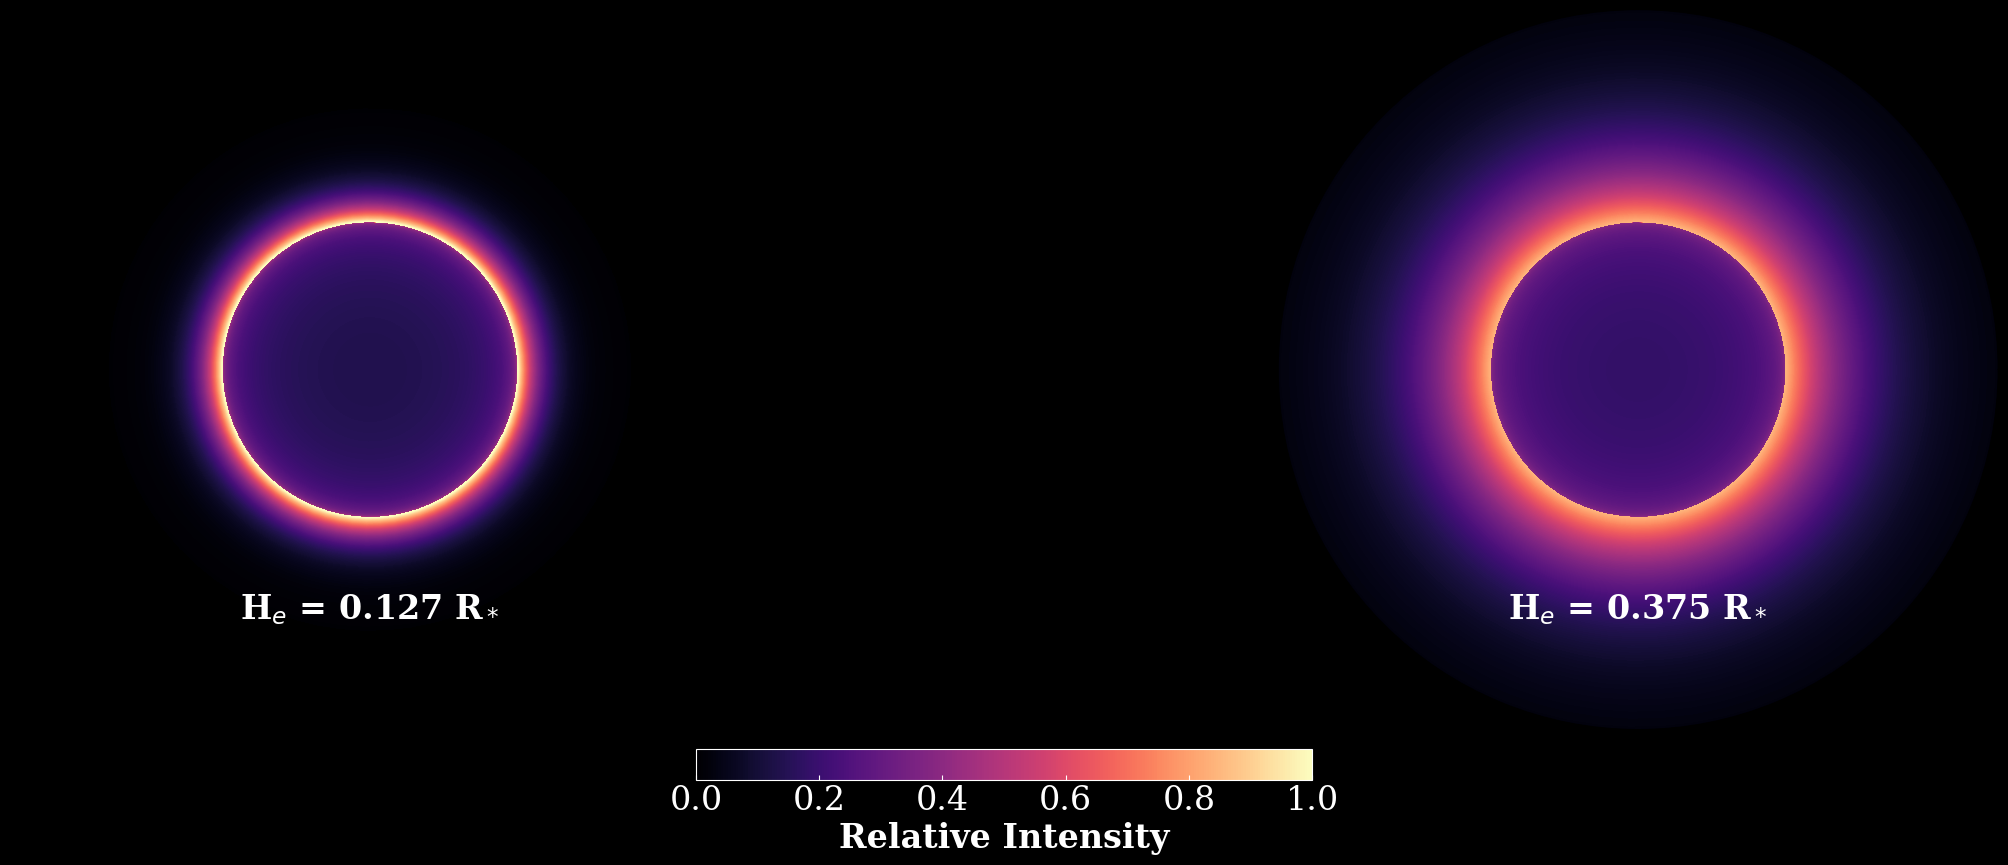

In [14]:
#set up azimuths and zeniths for contour plot
azimuths = np.radians(np.linspace(0, 360, 72))
zeniths = np.linspace(0, 1,10001)
#set up grid
r, theta = np.meshgrid(zeniths, azimuths)

#get values for first scale height choice
values1 = np.tile(intVals, (len(azimuths),1) )
#values normalised against the maximum value
val1N = values1 / np.max(values1)

#get values for second scale height choice
values2 = np.tile(intVals2, (len(azimuths),1) )
#values normalised against the maximum value of the first case and accounting for the difference in total emission
val2N = values2 / np.max(values1) * (np.sum(values1)/np.sum(values2))


#set up figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10), subplot_kw=dict(projection='polar'))

cmap = plt.colormaps.get_cmap("magma")

c = ax1.contourf(theta, r, val1N, 256, cmap=cmap)
c.set_clim( [0, np.max(val1N)] )

c2 = ax2.contourf(theta, r, val2N, 256, cmap=cmap)
c2.set_clim( [0, np.max(val1N)] )

ax1.xaxis.grid(False)
ax1.yaxis.grid(False)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_facecolor('black')

ax2.xaxis.grid(False)
ax2.yaxis.grid(False)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_facecolor('black')


pltparams = {"text.color" : "white",
          "xtick.color" : "white",
          "ytick.color" : "white"}
plt.rcParams.update(pltparams)

#Set up colorbar
cb = plt.colorbar(c, ax=[ax1,ax2], ticks=[0,0.2,0.4,0.6,0.8,1], fraction=0.04, pad=-0.1, location='bottom')
cb.set_label(label='Relative Intensity', fontsize=24, weight='bold', color='white')
cb.ax.tick_params(labelsize=24, labelcolor='white')
cb.outline.set_edgecolor('white')

#Add labels for each scale height value
ax2.text(1.5*np.pi, 0.5, 'H$_e$ = 0.375 R$_*$', horizontalalignment='center',  verticalalignment='center', color='white', weight='bold', fontsize=24)
ax1.text(1.5*np.pi, 0.5*(Rx/Rx2), 'H$_e$ = 0.127 R$_*$', horizontalalignment='center', verticalalignment='center', color='white', weight='bold', fontsize=24)

ax1.set_rlim([0, 0.75*(Rx/Rx2)]) #scales the plot with the smaller scale height value, so the size of each star is the same in the figure
ax2.set_rlim([0, 0.75]) 

fig.set_facecolor('black')

plt.subplots_adjust(bottom=0.16)

plt.savefig('2DCoronalModelComparison.png', dpi=300, facecolor='black')

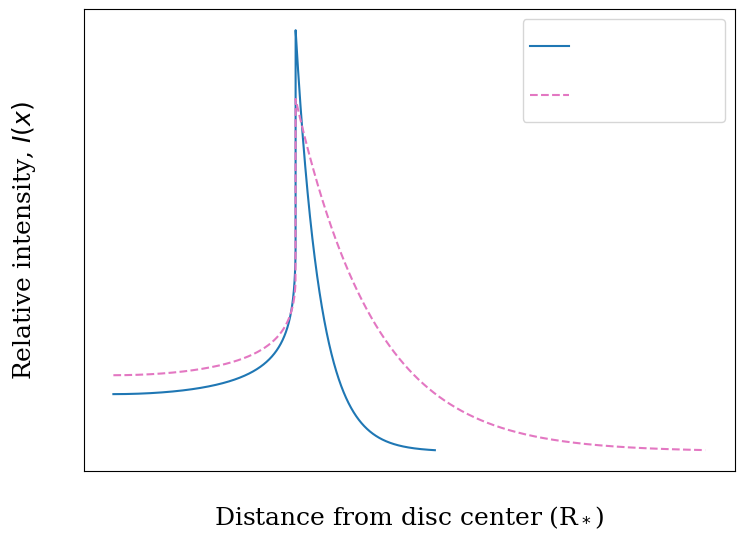

In [15]:
#First find the relative xcoords so we can plot on the same scale
x1Rel = x / Rx
x2Rel = x / Rx2
intVals2Rel = (intVals2/np.max(intVals)) * (np.sum(values1)/np.sum(values2))

#plot1D intensity variation
fig1D = plt.figure(figsize=(8.4,6.0))

plt.plot(x1Rel,intVals/np.max(values1), label='T=0.34 keV,\nHe=0.127 R$_*$')
plt.plot(x2Rel, intVals2Rel, color='C6', ls='--', label='T=1.0 keV,\nHe=0.375 R$_*$')

plt.xlabel('Distance from disc center (R$_*$)',fontsize=18)
plt.ylabel('Relative intensity, $I(x)$',fontsize=18)
plt.tick_params(labelsize=16)
plt.legend(loc='upper right', fontsize=14)

plt.savefig('1Dintensity_comp.pdf', dpi=300)

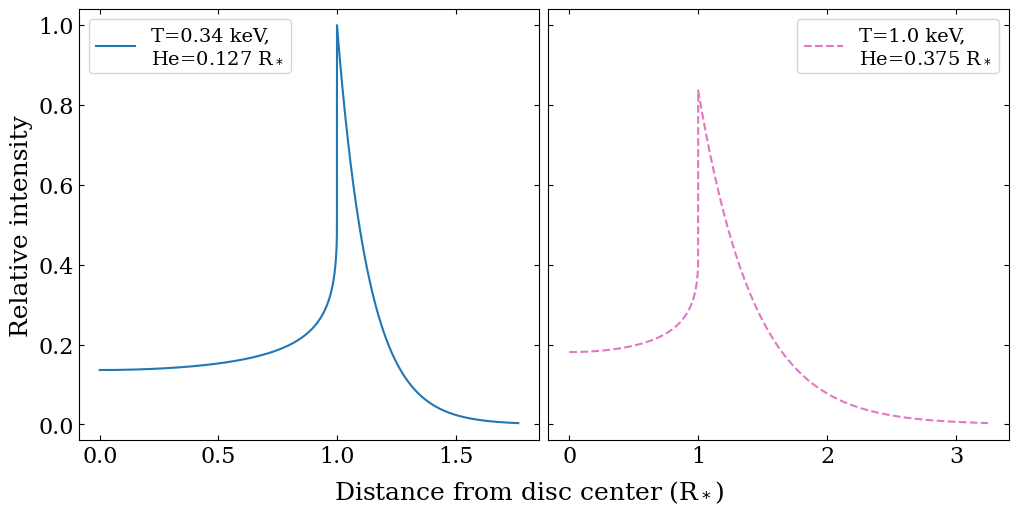

In [16]:
pltparams = {"text.color" : "k",
          "xtick.color" : "k",
          "ytick.color" : "k"}
plt.rcParams.update(pltparams)

#plot1D intensity variation
fig1D = plt.figure(figsize=(12.0,5.6))

ax1 = plt.subplot(121)

ax1.plot(x1Rel,intVals/np.max(intVals), label='T=0.34 keV,\nHe=0.127 R$_*$')

ax2 = plt.subplot(122)

ax2.plot(x2Rel, intVals2Rel, color='C6', ls='--', label='T=1.0 keV,\nHe=0.375 R$_*$')

ax1.set_ylabel('Relative intensity',fontsize=18)
ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax1.legend(loc='upper left', fontsize=14)
ax2.legend(loc='upper right', fontsize=14)
ax1.set_ylim(-0.04,1.04)
ax2.set_ylim(-0.04,1.04)
ax2.set_yticklabels([])

plt.subplots_adjust(wspace=0.02)
fig1D.text(0.5, 0.005, 'Distance from disc center (R$_*$)', ha='center', fontsize=18)

plt.savefig('1Dintensity_comp_alt.pdf', dpi=300)

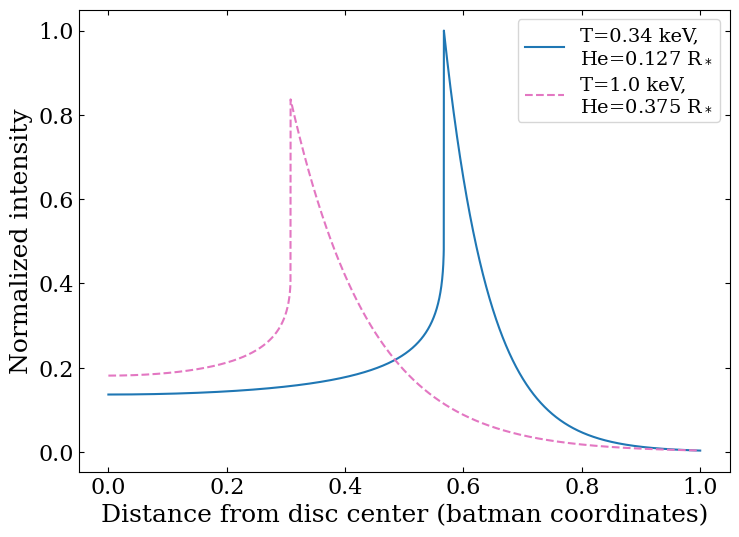

In [17]:
#plot1D intensity variation
fig1D = plt.figure(figsize=(8.4,6.0))

plt.plot(x, intVals/np.max(values1), label='T=0.34 keV,\nHe=0.127 R$_*$')
plt.plot(x, intVals2Rel, color='C6', ls='--', label='T=1.0 keV,\nHe=0.375 R$_*$')

plt.xlabel('Distance from disc center (batman coordinates)',fontsize=18)
plt.ylabel('Normalized intensity',fontsize=18)
plt.tick_params(labelsize=16)
plt.legend(loc='upper right', fontsize=14)

plt.savefig('1Dintensity_comp2.pdf', dpi=300)

# Add in two more cases: 0.05 keV and 2.0 keV

0.05 0.018732074353720048 0.016839447641898354 0.8989633141486099 [0.16221088 0.16221088 0.16221089 ... 0.00790813 0.0078617  0.00781554]


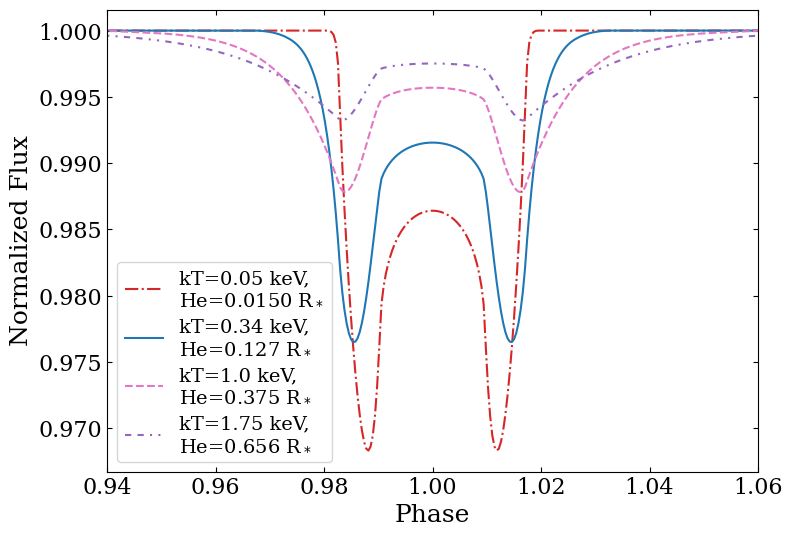

In [18]:
#temperatures to use (kT of corona in keV)
T3 = 0.05 
T4 = 1.75

#get emission scale height in stellar radii
He3 = xf.HfromT(T3, Rs, Ms)
He4 = xf.HfromT(T4, Rs, Ms)
#get emission scale height in batman coordinates
he3 = xf.hfromH(He3)
he4 = xf.hfromH(He4)

#photosphere edge in batman coords
Rx3 = xf.calcRx(he3, Nscale)
Rx4 = xf.calcRx(he4, Nscale)
#integral values
intVals3 = xf.get_intVals(he3, Nscale)
intVals4 = xf.get_intVals(he4, Nscale)

#set up the object to store the transit parameters
params3 = batman.TransitParams()
params3.t0 = t0               #time of inferior conjunction
params3.per = 1               #orbital period - set to 1 to keep within phase definitions
params3.rp = RpRs * Rx3        #planet radius (in units of stellar radii)
params3.a = aRs * Rx3          #semi-major axis (in units of stellar radii)
params3.inc = inc             #orbital inclination (in degrees)
params3.ecc = 0.              #eccentricity
params3.w = 90.               #longitude of periastron (in degrees)
params3.limb_dark = "custom"  #limb darkening model
params3.u = [0]*6             #limb darkening coefficients
params3.u[0] = intVals3

#set up the object to store the transit parameters
params4 = batman.TransitParams()
params4.t0 = t0               #time of inferior conjunction
params4.per = 1               #orbital period - set to 1 to keep within phase definitions
params4.rp = RpRs * Rx4        #planet radius (in units of stellar radii)
params4.a = aRs * Rx4          #semi-major axis (in units of stellar radii)
params4.inc = inc             #orbital inclination (in degrees)
params4.ecc = 0.              #eccentricity
params4.w = 90.               #longitude of periastron (in degrees)
params4.limb_dark = "custom"  #limb darkening model
params4.u = [0]*6             #limb darkening coefficients
params4.u[0] = intVals4

#set up batman model
mod3 = batman.TransitModel(params3, binPhases)
mod4 = batman.TransitModel(params4, binPhases)
#get the fluxes
flux3 = mod3.light_curve(params3)
flux4 = mod4.light_curve(params4)

pltparams = {"text.color" : "k",
          "xtick.color" : "k",
          "ytick.color" : "k"}
plt.rcParams.update(pltparams)

#plot the model
fig1234 = plt.figure(figsize=(8.4,6.0))

plt.plot(binPhases, flux3, color='C3', ls='-.', label='kT=0.05 keV,\nHe=0.0150 R$_*$')
plt.plot(binPhases, flux1, label='kT=0.34 keV,\nHe=0.127 R$_*$')
plt.plot(binPhases, flux2, color='C6', ls='--', label='kT=1.0 keV,\nHe=0.375 R$_*$')
plt.plot(binPhases, flux4, color='C4', ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)), label='kT=1.75 keV,\nHe=0.656 R$_*$')

plt.xlabel('Phase',fontsize=18)
plt.ylabel('Normalized Flux',fontsize=18)
plt.tick_params(labelsize=16)
plt.xlim(0.94,1.06)
plt.legend(loc='lower left', fontsize=14)

plt.savefig('varyHe4Temps.pdf', dpi=300)

In [19]:
print(intVals3)

[0.16221088 0.16221088 0.16221089 ... 0.00790813 0.0078617  0.00781554]


### Calculations

In [20]:
calcs(flux3, binPhases, '0.05 keV')
calcs(flux1, binPhases, '0.34 keV')
calcs(flux2, binPhases, '1.0 keV')
calcs(flux4, binPhases, '1.75 keV')

-------------------------------------------------
    ----Results for 0.05 keV----
    
    Maximum depth      = 3.168008402126654
    Average depth      = 1.6976910021438307
    Mid-transit depth  = 1.358900159658083
    Full duration      = 0.038877755511022016
    Trough to trough   = 0.023647294589178358
    Total missing flux = 0.06668285299001851
    
-------------------------------------------------
    ----Results for 0.34 keV----
    
    Maximum depth      = 2.3489339571795442
    Average depth      = 0.873579408707903
    Mid-transit depth  = 0.8448908194978566
    Full duration      = 0.06533066132264531
    Trough to trough   = 0.02925851703406801
    Total missing flux = 0.05742165251627167
    
-------------------------------------------------
    ----Results for 1.0 keV----
    
    Maximum depth      = 1.2173843186080058
    Average depth      = 0.35131495500885235
    Mid-transit depth  = 0.4307050511986654
    Full duration      = 0.1230460921843688
    Trough to tro

# Let's now investigate the difference that impact parameter makes. The measured inclination gives b = 0.66. Let's also try 0, 0.33, and 1.

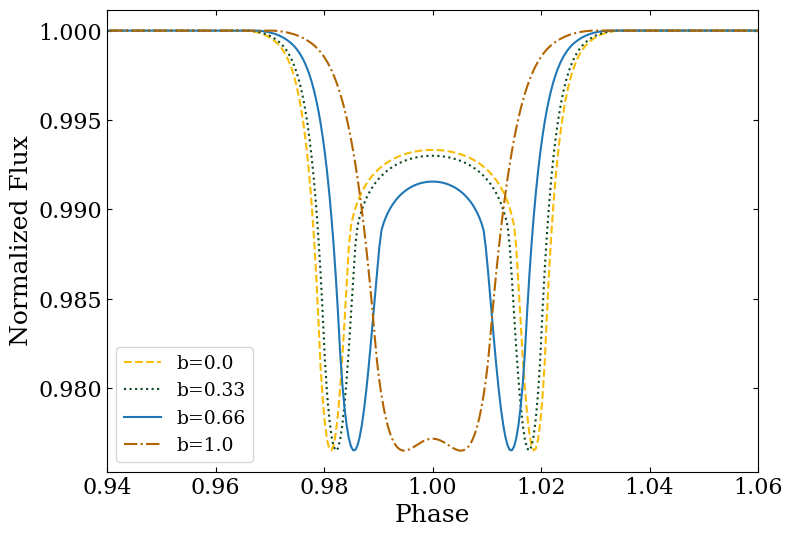

In [21]:
def inc_from_b(b, ars):
    inc = np.rad2deg( np.arccos(b / ars) )
    return inc
    
inc2 = inc_from_b(0.0, aRs)
inc3 = inc_from_b(0.33, aRs)
inc4 = inc_from_b(1.0, aRs)

params.inc = inc2
fluxb2 = mod.light_curve(params)
params.inc = inc3
fluxb3 = mod.light_curve(params)
params.inc = inc4
fluxb4 = mod.light_curve(params)

#plot the model
fig2 = plt.figure(figsize=(8.4,6.0))
plt.plot(binPhases, fluxb2, ls='--', label='b=0.0', color='#f9bc09')
plt.plot(binPhases, fluxb3, ls=':', label='b=0.33', color='#0a481e')
plt.plot(binPhases, flux1, label='b=0.66', color='C0') 
plt.plot(binPhases, fluxb4, ls='-.', color='#b26400', label='b=1.0')

plt.xlabel('Phase',fontsize=18)
plt.ylabel('Normalized Flux',fontsize=18)
plt.tick_params(labelsize=16)
plt.legend(loc='lower left', fontsize=13.5)
plt.xlim(0.94,1.06)

plt.savefig('varyImpactP.pdf', dpi=300)


### Calculations

In [22]:
calcs(fluxb2, binPhases, 'b=0.0')
calcs(fluxb3, binPhases, 'b=0.33')
calcs(flux1, binPhases, 'b=0.66')
calcs(fluxb4, binPhases, 'b=1.0')

-------------------------------------------------
    ----Results for b=0.0----
    
    Maximum depth      = 2.3495407339657493
    Average depth      = 0.7782362755952454
    Mid-transit depth  = 0.6677620691722286
    Full duration      = 0.06933867735470933
    Trough to trough   = 0.037274549098196275
    Total missing flux = 0.0542737923661607
    
-------------------------------------------------
    ----Results for b=0.33----
    
    Maximum depth      = 2.350248616194772
    Average depth      = 0.8051679486507091
    Mid-transit depth  = 0.7004249673350227
    Full duration      = 0.06773547094188381
    Trough to trough   = 0.03567134268537053
    Total missing flux = 0.05486114279383597
    
-------------------------------------------------
    ----Results for b=0.66----
    
    Maximum depth      = 2.3489339571795442
    Average depth      = 0.873579408707903
    Mid-transit depth  = 0.8448908194978566
    Full duration      = 0.06533066132264531
    Trough to trough   =

# Demonstrate the difference that time resolution makes to the model

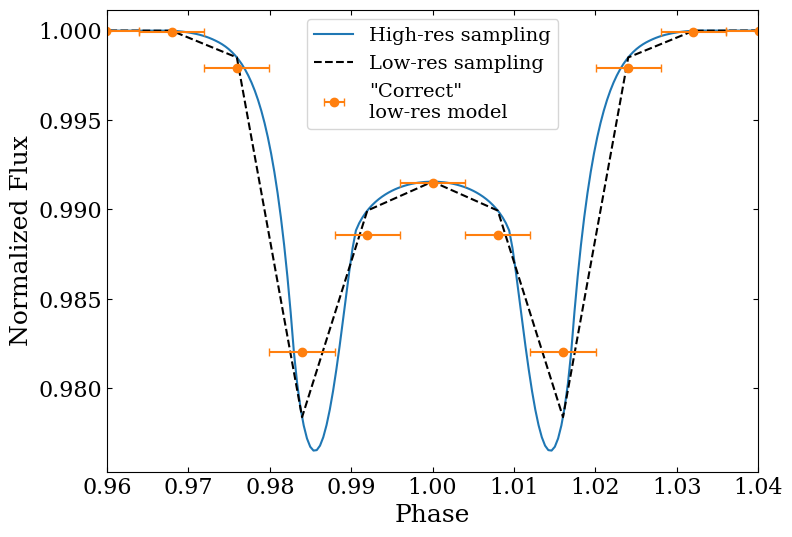

In [23]:
def centre_time(y):
    return ( y[-1] + y[0] ) / 2.

def time_range(y):
    return ( y[-1] + (np.diff(y)[-1] / 2.) ) - centre_time(y)


#bin the original time resolution model to the same cadence as the lower resolution
binNumbers = np.arange(len(binPhases)) // 20
#make table
tab = Table( [binPhases, flux1, binNumbers], names=['Phase','Flux','Bin'] )
#group table
tabGrp = tab.group_by('Bin')
#aggregate table
tabBin = tabGrp.groups.aggregate(np.mean)
#reaggregate the phases in each bin, by finding the centre point
tabBin['Phase'] = tabGrp['Phase'].groups.aggregate(centre_time)
#phase width of the bins - for the x error on the plot
tabBin['BinPhaSize'] = tabGrp['Phase'].groups.aggregate(time_range)

#revert inclination to the actual value
params.inc = inc

#set up batman model for comparison model assessed at same points as binned model
modSp = batman.TransitModel(params, tabBin['Phase'])
#fluxes
fluxSp = modSp.light_curve(params)


#plot all three time resolutions of the model together
figTimeRes = plt.figure(figsize=(8.4,6.0))
plt.plot(binPhases, flux1, label='High-res sampling')
plt.plot(tabBin['Phase'], fluxSp, color='k', ls='--', label='Low-res sampling')
plt.errorbar(tabBin['Phase'], tabBin['Flux'], ls='', marker='o', xerr=tabBin['BinPhaSize'],
             color='C1', label='"Correct"\nlow-res model')
#plt.plot(phasesDe, fluxDe, color='#ffc512', ls='--', label='%s bins' % numBinsDense)
plt.xlabel('Phase',fontsize=18)
plt.ylabel('Normalized Flux',fontsize=18)
plt.tick_params(labelsize=16)
plt.legend(loc='upper center', fontsize=14)
plt.xlim(0.96,1.04)

plt.savefig('timeRes_comparison.pdf', dpi=300)


# Final combined version of the plots for varying various parameters

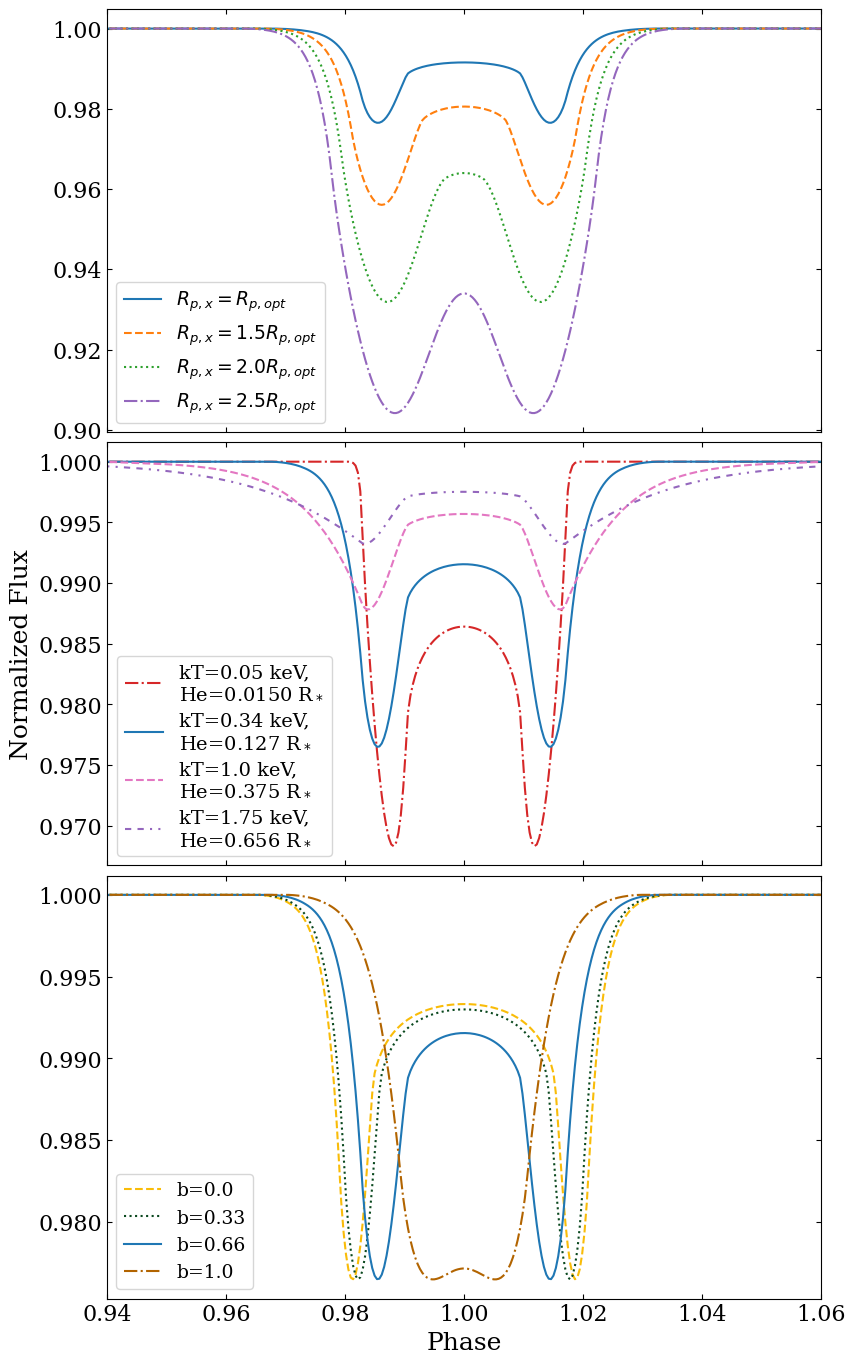

In [24]:
#plot the model
figComb = plt.figure(figsize=(8.4,13.6))


ax1 = figComb.add_subplot(311)

ax1.plot(binPhases, flux1, label='$R_{p,x} = R_{p,opt}$') 
ax1.plot(binPhases, flux15, ls='--', label='$R_{p,x} = 1.5 R_{p,opt}$')
ax1.plot(binPhases, flux20, ls=':', label='$R_{p,x} = 2.0 R_{p,opt}$')
ax1.plot(binPhases, flux25, ls='-.', color='C4', label='$R_{p,x} = 2.5 R_{p,opt}$')

ax1.set_xticklabels([])
ax1.tick_params(labelsize=16)
ax1.legend(loc='lower left', fontsize=13.5)
ax1.set_xlim(0.94,1.06)


ax2 = figComb.add_subplot(312)

ax2.plot(binPhases, flux3, color='C3', ls='-.', label='kT=0.05 keV,\nHe=0.0150 R$_*$')
ax2.plot(binPhases, flux1, label='kT=0.34 keV,\nHe=0.127 R$_*$')
ax2.plot(binPhases, flux2, color='C6', ls='--', label='kT=1.0 keV,\nHe=0.375 R$_*$')
ax2.plot(binPhases, flux4, color='C4', ls=(0, (3, 3, 3, 3, 1, 3, 1, 3)), label='kT=1.75 keV,\nHe=0.656 R$_*$')

ax2.set_xticklabels([])
ax2.set_ylabel('Normalized Flux',fontsize=18)
ax2.tick_params(labelsize=16)
ax2.set_xlim(0.94,1.06)
ax2.legend(loc='lower left', fontsize=14)


ax3 = figComb.add_subplot(313)

ax3.plot(binPhases, fluxb2, ls='--', label='b=0.0', color='#f9bc09')
ax3.plot(binPhases, fluxb3, ls=':', label='b=0.33', color='#0a481e')
ax3.plot(binPhases, flux1, label='b=0.66', color='C0') 
ax3.plot(binPhases, fluxb4, ls='-.', color='#b26400', label='b=1.0')

ax3.set_xlabel('Phase',fontsize=18)
ax3.tick_params(labelsize=16)
ax3.legend(loc='lower left', fontsize=13.5)
ax3.set_xlim(0.94,1.06)

plt.subplots_adjust(left=0.12, bottom=0.044, right=0.97, top=0.992, hspace=0.024)

plt.savefig('vary_comb.pdf')
